In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
res_3_df = pd.read_csv('results_1.3.csv')

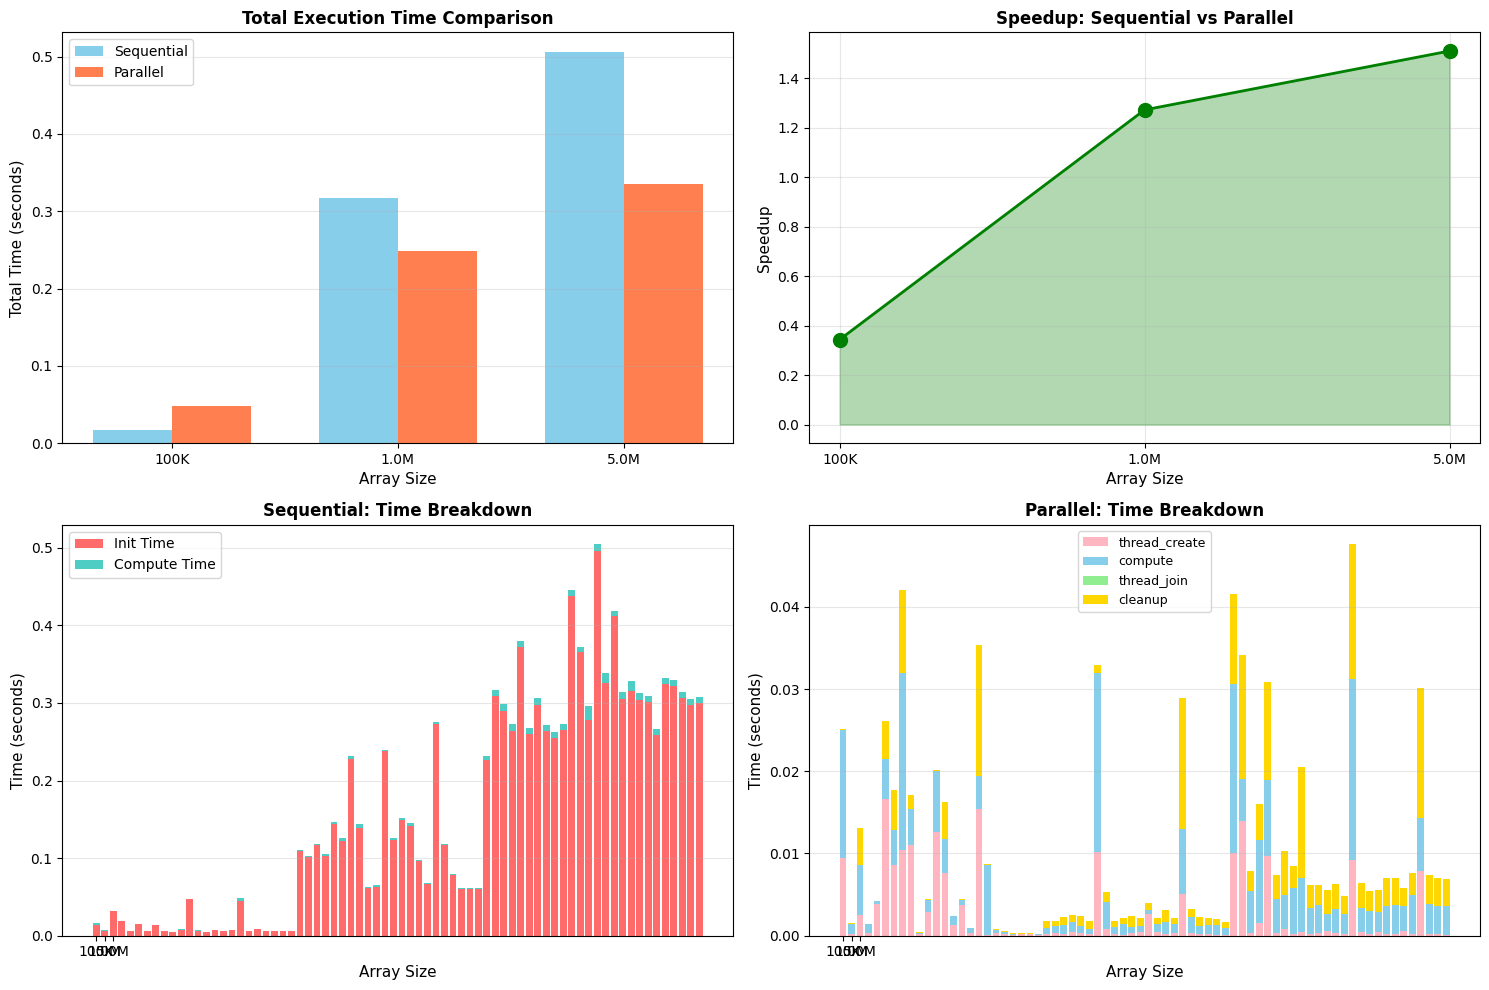

Array Analysis Summary:
  Size 100K: Speedup = 0.34x
  Size 1.0M: Speedup = 1.27x
  Size 5.0M: Speedup = 1.51x


In [3]:
# 1.3 Array Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sizes = sorted(res_3_df['size'].unique())

# Total execution time comparison
seq_times_3 = []
par_times_3 = []
size_labels = []

for size in sizes:
    size_data = res_3_df[res_3_df['size'] == size]
    seq_times_3.append(size_data[size_data['version'] == 'sequential']['time_total'].values[0])
    par_times_3.append(size_data[size_data['version'] == 'parallel']['time_total'].values[0])
    size_labels.append(f'{size/1e6:.1f}M' if size >= 1e6 else f'{size/1e3:.0f}K')

x_pos = np.arange(len(sizes))
width = 0.35

axes[0, 0].bar(x_pos - width/2, seq_times_3, width, label='Sequential', color='skyblue')
axes[0, 0].bar(x_pos + width/2, par_times_3, width, label='Parallel', color='coral')
axes[0, 0].set_xlabel('Array Size', fontsize=11)
axes[0, 0].set_ylabel('Total Time (seconds)', fontsize=11)
axes[0, 0].set_title('Total Execution Time Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(size_labels)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Speedup calculation
speedup_3 = np.array(seq_times_3) / np.array(par_times_3)
axes[0, 1].plot(range(len(sizes)), speedup_3, marker='o', linewidth=2, markersize=10, color='green')
axes[0, 1].fill_between(range(len(sizes)), speedup_3, alpha=0.3, color='green')
axes[0, 1].set_xlabel('Array Size', fontsize=11)
axes[0, 1].set_ylabel('Speedup', fontsize=11)
axes[0, 1].set_title('Speedup: Sequential vs Parallel', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(size_labels)
axes[0, 1].grid(True, alpha=0.3)

# Time breakdown for sequential
seq_breakdown = res_3_df[res_3_df['version'] == 'sequential'][['size', 'time_init', 'time_compute']].copy()
seq_breakdown = seq_breakdown.sort_values('size')

axes[1, 0].bar(range(len(seq_breakdown)), seq_breakdown['time_init'], label='Init Time', color='#FF6B6B')
axes[1, 0].bar(range(len(seq_breakdown)), seq_breakdown['time_compute'], 
              bottom=seq_breakdown['time_init'], label='Compute Time', color='#4ECDC4')
axes[1, 0].set_xlabel('Array Size', fontsize=11)
axes[1, 0].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 0].set_title('Sequential: Time Breakdown', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(size_labels)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Time breakdown for parallel
par_breakdown = res_3_df[res_3_df['version'] == 'parallel'][['size', 'time_thread_create', 'time_compute', 'time_thread_join', 'time_cleanup']].copy()
par_breakdown = par_breakdown.sort_values('size')

bottom_par = np.zeros(len(par_breakdown))
colors_par = ['#FFB6C1', '#87CEEB', '#90EE90', '#FFD700']
components = ['time_thread_create', 'time_compute', 'time_thread_join', 'time_cleanup']

for idx, comp in enumerate(components):
    axes[1, 1].bar(range(len(par_breakdown)), par_breakdown[comp], bottom=bottom_par, 
                  label=comp.replace('time_', ''), color=colors_par[idx])
    bottom_par += par_breakdown[comp].values

axes[1, 1].set_xlabel('Array Size', fontsize=11)
axes[1, 1].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 1].set_title('Parallel: Time Breakdown', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(size_labels)
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Array Analysis Summary:")
for i, size in enumerate(sizes):
    print(f"  Size {size_labels[i]}: Speedup = {speedup_3[i]:.2f}x")